# Task 3.2 : Mean squared-loss logistic regression

In our lectures we have covered using the log-likelihood loss function for logistic regression, but it is of course possible to use a wide range of loss functions. Consider for example the mean squared loss below which is common for regression tasks, but can also be applied for binary classification:

\begin{equation*}
\mathscr{L} = \frac{1}{n} \sum_{i=1}^n \frac{(y_i-\hat{y}_i)^2}{2}
\end{equation*}

In [45]:
#Importing libraries
import numpy as np
from matplotlib import pyplot as plt
from helpers import load_all_data, vectorized_flatten, sigmoid, gradient_update

In [46]:
def prep_data(data_path):
    """
    Prepare data
    Use vectorized flatten
    --------------------
    return: train, validation, and test splits
    --------------------
    """
    # Load
    x_train, y_train, x_dev, y_dev, x_test, y_test = load_all_data(data_path)
    
    # Flatten
    x_train_flattened = vectorized_flatten(x_train)
    x_dev_flattened = vectorized_flatten(x_dev)
    x_test_flattened = vectorized_flatten(x_test)
    
    # Reshape labels
    y_train = y_train.reshape(1, -1)
    y_dev = y_dev.reshape(1, -1)
    y_test = y_test.reshape(1, -1)
    
    # Return
    return(x_train_flattened, x_dev_flattened, x_test_flattened, y_train, y_dev, y_test)

In [47]:
data_path = '../setup/data'
x_train_flattened, x_dev_flattened, x_test_flattened, y_train, y_dev, y_test = prep_data(data_path)
print(y_dev.shape)

(1, 1000)


In [48]:
def predict(w: np.array, x: np.array, b: float) -> np.array:
        """
        Calculate the output predictions of sigmoid function:
        --------------------
        w: weights, of shape (1, 784)
        x: input data, of shape (784, n=12000)
        b: bias
        --------------------
        return: the predictions
        """
        
        activation_function_input = w@x + b
        
        return sigmoid(activation_function_input)

In [49]:
def gradient(x: np.array, y:np.array, w: np.array, b: float)-> (np.array, np.array):
        """
        Calculate the gradients: dw and db by using the answers from 1
        --------------------
        x: input data, of shape (784, n=12000)
        y: true label vector, of shape (1, n)
        --------------------
        return: derivatives of loss function: L with respect to weight: w and bias: b
        """
        # obtain number of samples
        n = max(y.shape)
        
        # predictions on entire data
        preds = predict(w, x, b)
        
        # derivative of loss function w.r.t. sigmoid function expressed as 'a'
        da = preds - y
        
        # derivative of loss function w.r.t. z (= w^Tx+b)
        dz = da * preds * (1 - preds)
        
        # derivative of loss function w.r.t. w
        dw = np.dot(dz, x.T)/n
        
        # derivative of loss function w.r.t. b
        db = np.sum(dz)/n
        
        return (dw, db)

In [50]:
def mean_squared_loss(y: np.array, y_pred: np.array) -> np.array:
        """
        Calculate the mean squared error.
        --------------------
        y: true label vector, of shape (1, n)
        y_pred: predicted label vector, of shape (1, n)
        --------------------
        return: mean squared loss
        """
        n = max(y.shape)
        return (y-y_pred)**2/(2*n)

In [51]:
 def finite_differences(x: np.array, y: np.array, w: np.array, b: float, epsilon=1e-5) -> (float, float):
        # obtain number of samples
        n = max(y.shape)
        
        # derive the loss function w.r.t. w and b respectively using the helper function 'gradient'
        dw, db = gradient(x, y, w, b)
        
        # add and subtract epsilon/2 from weights
        w_plus = np.copy(w) 
        w_minus = np.copy(w)
        
        w_plus += epsilon/2
        w_minus -= epsilon/2
        
        # predictions with w_plus and w_minus
        preds_w_plus = predict(w_plus, x, b)
        preds_w_minus = predict(w_minus, x, b)
        
        # calculate MSE using the helper function 'mean_squared_loss'
        loss_w_plus = mean_squared_loss(y, preds_w_plus)
        loss_w_minus =  mean_squared_loss(y, preds_w_minus)
        
        # calculate the right hand side of the finite difference equation
        fd_dw = (loss_w_plus - loss_w_minus)/(epsilon)
        
        # subtract the right hand side of the finite difference equation from the left
        difference_w = np.sum(dw) - np.sum(fd_dw)
        
        
        # add and subtract epsilon/2 from bias
        b_plus = b
        b_minus = b
        
        b_plus += epsilon/2
        b_minus -= epsilon/2
        
        # predictions with b_plus and b_minus
        preds_b_plus = predict(w, x, b_plus)
        preds_b_minus = predict(w, x, b_minus)
    
        # calculate MSE using the helper function 'mean_squared_loss'
        loss_b_plus = mean_squared_loss(y, preds_b_plus)
        loss_b_minus = mean_squared_loss(y, preds_b_minus)
        
        # calculate the right hand side of the finite difference equation
        fd_db = (loss_b_plus - loss_b_minus)/(epsilon)
        
        # subtract the right hand side of the finite difference equation from the left
        difference_b = np.sum(db) - np.sum(fd_db)
        
        return (difference_w, difference_b)

In [52]:
a, b=finite_differences(x_train_flattened, y_train, np.zeros((x_train_flattened.shape[0], )), 0)
print("For analytical gradient w.r.t. w:", a ,"= {:.15f}".format(float(a)))
print("For analytical gradient w.r.t. b:", b ,"= {:.15f}".format(float(b)))

For analytical gradient w.r.t. w: -1.6553629329507658e-06 = -0.000001655362933
For analytical gradient w.r.t. b: -1.0164395367051604e-12 = -0.000000000001016


In [53]:
def accuracy(y, y_pred):
    """
    Calculate the accuracy on given data.
    --------------------
    y: true label vector, of shape (1, n)
    y_pred: predicted label vector, of shape (1, n)
    --------------------
    return: accuracy
    """
    n = max(y_pred.shape)
    correct = np.sum(np.where(y == y_pred, 1.0, 0.0))
    return correct/n

In [54]:
def train(x: np.array, y: np.array, x_dev: np.array, y_dev: np.array, w: np.array, b: float, n_epochs: int, learning_rate: float, n_limit: int) -> (list, list, list):
        """
        Calculate the accuracy on given data.
        --------------------
        x: input training data, of shape (784, n=12000)
        y: true training label vector, of shape (1, n)
        x_dev: input validation data, of shape (784, m =1000)
        y_dev: true validation label vector, of shape (1, m)
        w: weights, of shape (1, 784)
        b: bias
        n_epochs: number of times training the data
        learning_rate: learning rate
        n_limit: number of epochs for which we would consider the process to have converged
        --------------------
        return: lists of training losses, accuracies on training data and accuracies on validation data
        """
        # count the number of validation loss increments
        counter = 0
        
        # store training square loss, accuracy on the training set and accuracy on the validation set for each epoch
        training_losses = []
        validation_losses = []
        training_accuracies = []
        validation_accuracies = []
        weights = []
        biases = []
        
        for i in range(n_epochs):
            # predictions on training data
            preds = predict(w, x, b)
            
            # gradients w.r.t. w and b
            dw, db = gradient(x, y, w, b)
            
            # update the model parameters, w and b, and store them in corresponding lists
            w = gradient_update(w, learning_rate, dw)
            b = gradient_update(b, learning_rate, db)
            
            weights.append(w)
            biases.append(b)
            
            # calculate training loss and append to the list, training_losses
            training_loss = np.sum(mean_squared_loss(y, preds))
            training_losses.append(training_loss)
            
            # calculate training accuracy and append to the list, training_accuracies
            training_accuracy = accuracy(y, np.where(preds >= 0.5, 1.0, 0.0))
            training_accuracies.append(training_accuracy)
            
            # predictions on validation data
            preds_dev = predict(w, x_dev, b)
            
            # calculate validation accuracy and append to the list, validation_accuracies
            validation_accuracy = accuracy(y_dev, np.where(preds_dev >= 0.5, 1.0, 0.0))
            validation_accuracies.append(validation_accuracy)
            
            # calculate validation loss and append to the list, validation_losses
            validation_loss = np.sum(mean_squared_loss(y_dev, preds_dev))
            validation_losses.append(validation_loss)
            
            # increment the counter if validation loss is greater than previous one 
            if i > 0 and validation_loss > prev_validation_loss:
                counter += 1
            
            # break the loop if the validation loss increases for "n_limit" epochs
            if counter == n_limit:
                print("reached limit")
                break
            
            # store the current validation loss for the next iteration
            prev_validation_loss = validation_loss
        
        # prints the model parameters that minimise the MSE of the model
        training_epoch = np.argmin(training_losses)
#         print("Weights that minimise the MSE of the model: ", weights[training_epoch])
#         print("Bias that minimises the MSE of the model: ", biases[training_epoch])
        
        return (training_losses, validation_losses, training_accuracies, validation_accuracies)

In [55]:
losses, validation_losses, training_accuracies, validation_accuracies = train(x_train_flattened, y_train, x_dev_flattened, y_dev, np.zeros((x_train_flattened.shape[0], )), 0, 500, 0.1, 5)


In [56]:
# Establish a “grid” based on intuitions regarding the model.
learningrates = [0.1, 0.01, 0.001]
# batchsizes    = [32, 64, 128, 256, length(data)]
# momentums     = [0.95, 0.9, 0.0]

min_loss = float('inf')
max_accuracy = float('-inf')

for learningrate in learningrates:
    # Train and evaluate the model with the given parameters on the validation set.
    losses, validation_losses, training_accuracies, validation_accuracies = train(x_train_flattened, y_train, x_dev_flattened, y_dev, np.zeros((x_train_flattened.shape[0], )), 0, 500, learningrate, 5)
    
    # find the minimum validation loss and the maximum validation accuracy with current learningrate
    validation_loss = np.amin(validation_losses)
    validation_accuracy = np.amax(validation_accuracies)
    
    print("loss:", validation_loss, "Acc:", validation_accuracy)
    # update the minimum loss and the maximum accuracy as well as learning rate
    if validation_loss < min_loss:
        min_loss = validation_loss
        min_loss_lr = learningrate
        
    if validation_accuracy > max_accuracy:
        max_accuracy = validation_accuracy
        min_acc_lr = learningrate

print(min_loss_lr, min_acc_lr)
# Pick the model with the best performance on validation data

loss: 0.021546193651713324 Acc: 0.961
loss: 0.05131401483471375 Acc: 0.918
loss: 0.09925195550861525 Acc: 0.784
0.1 0.1


(-1.6553629329507658e-06, -1.0164395367051604e-12)
500
weights that minimise the MSE of the model:  [[-1.19533279e-02 -1.19081835e-02 -1.14719831e-02 -1.10210680e-02
  -9.64005263e-03 -6.96497585e-03 -4.52628332e-03  1.11808029e-03
   7.37520541e-03  1.46778911e-02  2.34253414e-02  3.27185591e-02
   3.88622607e-02  4.51524551e-02  4.21149159e-02  2.09359951e-02
   1.24674246e-03 -6.51513942e-03 -3.75655811e-03 -1.72667142e-03
  -6.34414327e-03 -8.55137477e-03 -6.78257019e-03 -8.79407159e-03
  -1.07691360e-02 -1.08238783e-02 -1.25145902e-02 -1.18722305e-02
  -1.19408666e-02 -1.16056932e-02 -1.07139185e-02 -7.04663761e-03
  -1.18184900e-03  8.90622285e-03  1.88725902e-02  3.39776610e-02
   4.96187431e-02  7.01762327e-02  9.23651489e-02  1.08344052e-01
   1.17570960e-01  1.21397562e-01  1.03201500e-01  5.91593257e-02
   3.04272854e-02  1.59963537e-02  1.54397090e-02  1.81419091e-02
   1.20841556e-02  6.05664657e-03  2.45977000e-03 -1.71351391e-03
  -3.72829202e-03 -1.78912357e-03 -8.54396

Training accuracy on epoch 314 = 0.9539166666666666
Validation accuracy on epoch 314 = 0.961


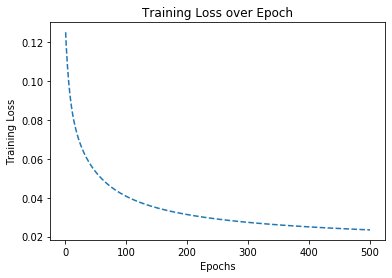

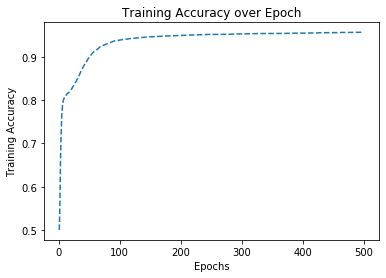

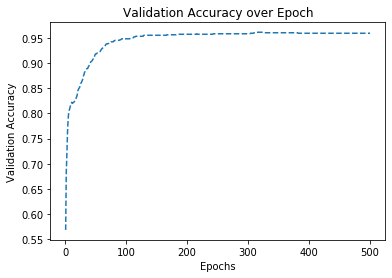

In [12]:
import numpy as np
from matplotlib import pyplot as plt

# @dataclass
class LogisticRegression:
    w: np.array
    b: float
    learning_rate: float
    n_epochs: int
    
    def __init__(self, weight, bias, learning_rate, n_epochs):
        self.w = weight
        self.b = bias
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
    
    def activation_function_input(self, w: np.array, x: np.array) -> np.array:
        """
        Calculate the input of activation function.
        --------------------
        w: current weight, of shape (1, 784)
        x: input data, of shape (784, n=12000)
        --------------------
        return: the output prediction
        """
        
        return w@x + self.b
    
    def predict(self, x) -> np.array:
        """
        Calculate the output prediction.
        --------------------
        x: input data, of shape (784, n=12000)
        --------------------
        return: the output prediction
        """
        
        activation_function_input = self.activation_function_input(self.w, x)
        
        return sigmoid(activation_function_input)
    
    def gradient(self, x, y)-> (np.array, np.array):
        """
        Calculate the gradients: dw and db
        --------------------
        x: input data, of shape (784, n=12000)
        y: true label vector, of shape (1, n)
        --------------------
        return: derivatives of loss function: L with respect to weight: w and bias: b
        """
        n = max(y.shape)
        
        p = self.predict(x)
        
        dy_hat = p-y
        dz = dy_hat*p*(1-p)
        
        dw = np.dot(dz, x.T)/n
        db = np.sum(dz)/n
        
        return (dw, db)
    
    def mean_squared_loss(self, y, y_pred) -> np.array:
        """
        Calculate the mean squared error.
        --------------------
        y: true label vector, of shape (1, n)
        y_pred: predicted label vector, of shape (1, n)
        --------------------
        return: mean squared loss
        """
        n = max(y.shape)
        return (y-y_pred)**2/(2*n)
    
    def finite_differences(self, x, y, delta_h=1e-5):
        """
        Calculate the finite difference.
        --------------------
        gradients: Current set of gradients
        learning_rate: parameter to guide SGD step size
        --------------------
        return: finite difference
        """
        
        n = max(y.shape)
        
        dw = self.gradient(x, y)[0]
        db = self.gradient(x, y)[1]
        
        w_plus = np.copy(self.w)
        w_minus = np.copy(self.w) 
        
        b_plus = self.b
        b_minus = self.b
        
        w_plus += delta_h/2
        w_minus -= delta_h/2
        
        b_plus += delta_h/2
        b_minus -= delta_h/2
        
        y_hat_plus_w = sigmoid(w_plus @ x + self.b)
        y_hat_minus_w = sigmoid(w_minus @ x + self.b)
        
        y_hat_plus_b = sigmoid(self.w @ x + b_plus)
        y_hat_minus_b = sigmoid(self.w @ x + b_minus)
    
        
        loss_plus_w = self.mean_squared_loss(y, y_hat_plus_w)
        loss_minus_w =  self.mean_squared_loss(y, y_hat_minus_w)
        
        loss_plus_b = self.mean_squared_loss(y, y_hat_plus_b)
        loss_minus_b =  self.mean_squared_loss(y, y_hat_minus_b)
        
        fd_dw = (loss_plus_w - loss_minus_w)/(delta_h)
        fd_db = (loss_plus_b - loss_minus_b)/(delta_h)
        
        difference_w = np.sum(dw) - np.sum(fd_dw)
        difference_b = np.sum(db) - np.sum(fd_db)
        
        return (difference_w, difference_b)
    
    def train(self, x, y, x_dev, y_dev, bound):
        # count the number of validation loss increments
        counter = 0
        
        losses = []
        training_accuracies = []
        validation_accuracies = []
        weights = []
        biases = []
        
        for i in range(self.n_epochs):
            y_hat = self.predict(x)
#             print(y_hat)
            dw, db = self.gradient(x, y)
            self.w = gradient_update(self.w, self.learning_rate, dw)
            self.b = gradient_update(self.b, self.learning_rate, db)
#             print(self.b)
            weights.append(self.w)
            biases.append(self.b)
            
            training_loss = np.sum(self.mean_squared_loss(y, y_hat))
            losses.append(training_loss)
            
            training_accuracy = self.accuracy(y, np.where(y_hat >= 0.5, 1.0, 0.0))
            training_accuracies.append(training_accuracy)
            
            y_dev_hat = self.predict(x_dev)
            
            validation_accuracy = self.accuracy(y_dev, np.where(y_dev_hat >= 0.5, 1.0, 0.0))
            validation_accuracies.append(validation_accuracy)
            
            validation_loss = np.sum(self.mean_squared_loss(y_dev, y_dev_hat))
            
            if i > 0 and validation_loss > prev_validation_loss:
                print("increment")
                counter += 1
            
            if counter == bound:
                print("reached bound")
                break
            #print(validation_loss)
            prev_validation_loss = validation_loss
        
        # 
        training_epoch = np.argmin(losses)
        print(training_epoch+1)
        print("weights that minimise the MSE of the model: ", weights[training_epoch])
        print("bias that minimises the MSE of the model: ", biases[training_epoch])
        return (losses, training_accuracies, validation_accuracies)
    
    def accuracy(self, y, y_hat):
        n = max(y_hat.shape)
        correct = np.sum(np.where(y == y_hat, 1.0, 0.0))
#         correct = np.sum(y_hat >= 0.5)
        return correct/n
    
    def plot(self, y_values, xlabel, ylabel, title, output_path):
        epochs = range(1, self.n_epochs+1)

        plt.figure()
        plt.plot(epochs, y_values, linestyle='--')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
#         plt.show()
        plt.savefig(output_path)

p = LogisticRegression(np.zeros((x_train_flattened.shape[0], )), 0, 0.1, 500)
print(p.finite_differences(x_train_flattened, y_train))
losses, training_accuracies, validation_accuracies = p.train(x_train_flattened, y_train, x_dev_flattened, y_dev, 5)
print(type(losses))
p.plot(losses, 'Epochs', 'Training Loss', 'Training Loss over Epoch', 'trainingLoss_epochs.png')
p.plot(training_accuracies, 'Epochs', 'Training Accuracy', 'Training Accuracy over Epoch', 'trainingAcc_epochs.png')
p.plot(validation_accuracies, 'Epochs', 'Validation Accuracy', 'Validation Accuracy over Epoch', 'validationAcc_epochs.png')

# training_epoch = np.argmax(training_accuracies)
validation_epoch = np.argmax(validation_accuracies)
print("Training accuracy on epoch {} = {}".format(validation_epoch+1, training_accuracies[validation_epoch]))
print("Validation accuracy on epoch {} = {}".format(validation_epoch+1, validation_accuracies[validation_epoch]))